# The Geometry of Superposition

In [588]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from model import Model, learning

## Uniform Superposition

In [589]:
n = 400
m = 30

num = 10000

n_instances = 10
S =  (20 ** -torch.linspace(0, 1, n_instances))[:, None]


n_instances = len(S)

X = np.random.rand(num, n)
importances = torch.tensor([1 for k in range(n)])

In [590]:
S.shape

torch.Size([10, 1])

In [591]:
model = Model(n, m, S,  n_instances)
no_linear_model = learning(model, X, importances, n, 10000)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.29it/s]


In [9]:
def paint_(model, m, S):
    y = m / torch.norm(model.W, p='fro', dim=[1,2]) ** 2
    plt.plot(np.linspace(1, 10, len(S)), y.detach().numpy())
    plt.xticks(np.arange(0, 11, step=1))
    plt.xscale('log')
    plt.show()
    #plt.grid()

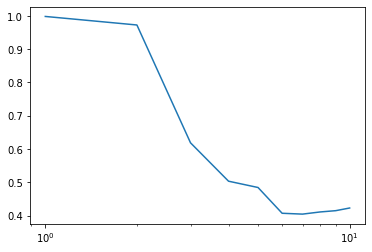

In [10]:
paint_(no_linear_model[0], m, S)

In [592]:
import plotly.express as px
fig = px.line(
    x=1/no_linear_model[0].feature_probability[:, 0].cpu(),
    y=(m/(torch.linalg.matrix_norm(no_linear_model[0].W.detach(), 'fro')**2)).cpu(),
    
    log_x=True,
    markers=True,
)
fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/||W||_F^2")

In [13]:
def count_dimensionality(model, S, n):
    
    W = model.W.detach()
    W_norm = torch.linalg.norm(W, 2, dim=-1, keepdim=True)
    #print(W_norm.shape)
    interference = torch.einsum('ifh,igh->ifg', W / (1e-5 + W_norm), W)
    interference[:, torch.arange(n), torch.arange(n)] = 0
    polysemanticity = torch.linalg.norm(interference, dim=-1)
    
    #print( W_norm.shape, polysemanticity.shape)
    x = np.linspace(1, 10, len(S))
    x = np.repeat(x, n)
    print(x.shape)
    print(W_norm.shape)
    D_tensor = ((W_norm.reshape(W_norm.shape[0], W_norm.shape[1]) ** 2 )/ (polysemanticity ** 2)).reshape(-1)
    print( D_tensor.shape)
    plt.scatter(x, D_tensor)
    plt.xscale('log')
    return D_tensor

(4000,)
torch.Size([10, 400, 1])
torch.Size([4000])


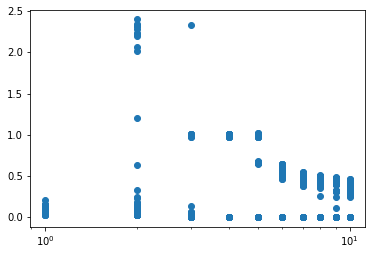

In [14]:
n = 400
S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]
a = count_dimensionality(no_linear_model[0], S, n)

In [15]:
import plotly.graph_objects as go

In [16]:
@torch.no_grad()
def compute_dimensionality(W):
    norms = torch.linalg.norm(W, 2, dim=-1) 
    W_unit = W / torch.clamp(norms[:, :, None], 1e-6, float('inf'))

    interferences = (torch.einsum('eah,ebh->eab', W_unit, W)**2).sum(-1)

    dim_fracs = (norms**2/interferences)
    return dim_fracs.cpu()

In [17]:
dim_fracs = compute_dimensionality(no_linear_model[0].W)

In [18]:
fig = go.Figure()

density = no_linear_model[0].feature_probability[:, 0].cpu()
W = no_linear_model[0].W.detach()

for a,b in [(1,2), (2,3), (2,5), (2,6), (2,7)]:
    val = a/b
    fig.add_hline(val, line_color="purple", opacity=0.2, annotation=dict(text=f"{a}/{b}"))

for a,b in [(5,6), (4,5), (3,4), (3,8), (3,12), (3,20)]:
    val = a/b
    fig.add_hline(val, line_color="blue", opacity=0.2, annotation=dict(text=f"{a}/{b}", x=0.05))

for i in range(len(W)):
    fracs_ = dim_fracs[i]
    N = fracs_.shape[0]
    xs = 1/density
    if i!= len(W)-1:
        dx = xs[i+1]-xs[i]
    fig.add_trace(
        go.Scatter(
            x=1/density[i]*np.ones(N)+dx*np.random.uniform(-0.1,0.1,N),
            y=fracs_,
            marker=dict(
                color='black',
                size=1,
                opacity=0.5,
            ),
            mode='markers',
        )
    )

fig.update_xaxes(
    type='log', 
    title='1/(1-S)',
    showgrid=False,
)
fig.update_yaxes(
    showgrid=False
)
fig.update_layout(showlegend=False)

In [66]:
@torch.no_grad()
def compute_dimensionality_05(W):
    norms = torch.linalg.norm(W, 2, dim=-1) 
    W_unit = W / torch.clamp(norms[:, :, None], 1e-6, float('inf'))

    interferences = (torch.einsum('eah,ebh->eab', W_unit, W)**2).sum(-1)

    dim_fracs = (norms**2/interferences)
    return dim_fracs.cpu()

In [195]:
my_dim = compute_dimensionality_05(no_linear_model[0].W)[3]

In [196]:
my_W = no_linear_model[0].W[3]

In [212]:
my_idxs = np.where(abs(my_dim-0.5) < 0.1)[0]

In [213]:
my_idxs

array([  4,  16,  18,  36,  37,  67,  80, 103, 104, 109, 113, 118, 123,
       126, 144, 150, 152, 165, 166, 169, 172, 182, 186, 189, 192, 199,
       214, 216, 220, 223, 224, 225, 231, 237, 244, 246, 249, 255, 262,
       268, 290, 291, 292, 298, 299, 316, 317, 319, 337, 350, 361, 373,
       378, 385, 391, 396, 398, 399])

In [221]:
#my_W_2 = my_W[my_idxs].T@my_W[my_idxs]
my_W_2 = my_W @ my_W.T
my_W_2 = my_W_2[my_idxs]
my_W_2 = my_W_2[:,my_idxs]

In [281]:
my_W.shape

torch.Size([400, 30])

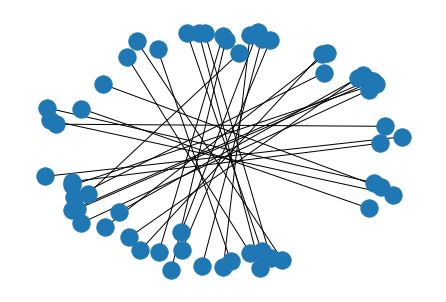

In [269]:
data = my_W_2.detach().numpy().copy()
for i in range(len(data)):
    data[i, i] = 0

data[abs(data) < 0.01] = 0
G = nx.from_numpy_array(data)
nx.draw(G)

## Aside: Polytopes and Low-Rank Matrices

In [272]:
n = 100
m = 3

num = 10000

S =  torch.tensor([0.4])
S = S.reshape(len(S),-1)

n_instances = len(S)

X = np.random.rand(num, n)
importances = torch.tensor([1 for k in range(n)])

In [273]:
model_aside = Model(n, m, S,  n_instances)
no_linear_model_aside = learning(model_aside, X, importances, n, 10000)

100%|████████████████████████████████████| 10000/10000 [00:24<00:00, 403.87it/s]


In [274]:
no_linear_model_aside[0].W[0].T @ no_linear_model_aside[0].W[0]

tensor([[ 1.7643,  0.2856, -0.3365],
        [ 0.2856,  1.6943,  0.3782],
        [-0.3365,  0.3782,  1.5660]], grad_fn=<MmBackward0>)

## Non-Uniform Superposition 

In [275]:
n = 5
m = 2

num = 10000

n_instances = 20
S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]


X = np.random.rand(num, n)
importances = torch.tensor([1 for k in range(n)])

In [286]:
model_aside = Model(n, m, S,  n_instances)
no_linear_model_aside = learning(model_aside, X, importances, n, 10000)

100%|████████████████████████████████████| 10000/10000 [00:36<00:00, 276.43it/s]


In [287]:
no_linear_model_aside[0].W[0].T @ no_linear_model_aside[0].W[0]

tensor([[1.0030, 0.0037],
        [0.0037, 1.0061]], grad_fn=<MmBackward0>)

## Correlated and Anticorrelated Features

In [568]:
import torch
import tqdm
import torch.nn.utils
import einops
from torch.nn import functional as F


class Model(torch.nn.Module):
    def __init__(self,n_features, n_hidden, S, n_instances=10, corel_flag=True,
active=True):
        super().__init__()
        self.W = torch.nn.Parameter(torch.empty((n_instances, n_features, 
n_hidden)))
        torch.nn.init.xavier_normal_(self.W)
        self.b_final = torch.nn.Parameter(torch.zeros((n_instances, 
n_features)))
        self.active = active
        
        self.feature_probability = S
        self.n_instances = n_instances
        self.n_features = n_features
        self.corel_flag = True
    
        
    def forward(self, features):

        hidden = torch.einsum("...if,ifh->...ih", features, self.W)

        out = torch.einsum("...ih,ifh->...if", hidden, self.W)

        zout = out + self.b_final
        if self.active:
            out = F.relu(out)
        return out
    
    def generate_batch(self, n_batch):
        feat = torch.rand((n_batch, self.n_instances, self.n_features))

        rand_prob = torch.rand((n_batch, self.n_instances, self.n_features))
        if self.corel_flag:
            for i in range(0,rand_prob.size(2), 2):
                rand_prob[:,:,i+1:i+2] = rand_prob[:,:,i:i+1]
            
#         else:
#             for i in range(0,rand_prob.size(2),2):
#                 rand_prob[:,:,i+1:i+2] = torch.zeros_like(rand_prob[:,:,i+1:i+2])
       
            
        batch = torch.where(
            rand_prob <= 
self.feature_probability,
            feat,
            torch.zeros(()),
        )
        #print(batch.shape)
        
        if not self.corel_flag:
            for i in range(0, batch.shape[2], 2):
                mask = batch[:,:,i] != 0
                batch[:,:,i+1][mask] = 0 
                

        return batch


def learning(model, importances, n, epoch=10000, lr=0.001, 
batch_size=1024
             ):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


    for epoch in tqdm.tqdm(range(epoch)):

    

        optimizer.zero_grad()

        batch = model.generate_batch(batch_size)

        
        out = model(batch)
        
        error = (importances*(batch.abs() - out)**2)
        loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
        
        loss.backward() 

        optimizer.step()
    return model


#### Correl

In [579]:
n = 4
m = 2

num = 10000


n_instances = 20
S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]

importances = torch.tensor([1 for k in range(n)])

In [535]:
model_cor = Model(n, m, S,  n_instances, corel_flag=True)
no_linear_model_cor = learning(model_cor, importances, n, 10000)

100%|████████████████████████████████████| 10000/10000 [00:37<00:00, 266.51it/s]


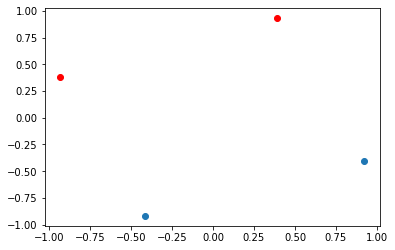

In [538]:
plt.scatter(no_linear_model_cor.W[19][:,0].detach().numpy()[:2],\
            no_linear_model_cor.W[19][:,1].detach().numpy()[:2], marker='o', color = 'red')
plt.scatter(no_linear_model_cor.W[19][:,0].detach().numpy()[2:],\
            no_linear_model_cor.W[19][:,1].detach().numpy()[2:], marker='o')

#### anticorr

In [580]:
model_anticor = Model(n, m, S,  n_instances, corel_flag=False)
no_linear_model_anticor = learning(model_anticor, importances, n, 10000)

100%|████████████████████████████████████| 10000/10000 [00:41<00:00, 242.11it/s]


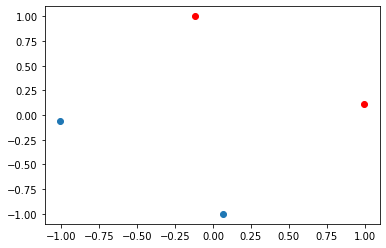

In [581]:
plt.scatter(no_linear_model_anticor.W[19][:,0].detach().numpy()[:2],\
            no_linear_model_anticor.W[19][:,1].detach().numpy()[:2], marker='o')
plt.scatter(no_linear_model_anticor.W[19][:,0].detach().numpy()[2:],\
            no_linear_model_anticor.W[19][:,1].detach().numpy()[2:], marker='o', color='red')

In [576]:
n = 6
m = 2

num = 10000

n_instances = 20
S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]

importances = torch.tensor([1 for k in range(n)])

In [577]:
model_cor6 = Model(n, m, S,  n_instances, corel_flag=True)
no_linear_model_cor6 = learning(model_cor6, importances, n, 10000)

100%|████████████████████████████████████| 10000/10000 [00:44<00:00, 225.59it/s]


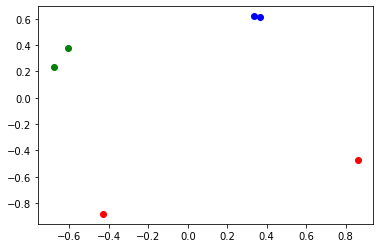

In [578]:
colors = ['blue', 'red', 'green']
for i in range(0, n , 2):
    plt.scatter(no_linear_model_cor6.W[-1][:,0].detach().numpy()[i:i+2],\
            no_linear_model_cor6.W[-1][:,1].detach().numpy()[i:i+2], marker='o', color=colors[i//2])

### LOCAL ALMOST-ORTHOGONAL BASES

In [553]:
class Model(torch.nn.Module):
    def __init__(self,n_features, n_hidden, S, n_instances=10, corel_flag=True,
active=True):
        super().__init__()
        self.W = torch.nn.Parameter(torch.empty((n_instances, n_features, 
n_hidden)))
        torch.nn.init.xavier_normal_(self.W)
        self.b_final = torch.nn.Parameter(torch.zeros((n_instances, 
n_features)))
        self.active = active
        
        self.feature_probability = S
        self.n_instances = n_instances
        self.n_features = n_features
        self.corel_flag = True
    
        
    def forward(self, features):

        hidden = torch.einsum("...if,ifh->...ih", features, self.W)

        out = torch.einsum("...ih,ifh->...if", hidden, self.W)

        zout = out + self.b_final
        if self.active:
            out = F.relu(out)
        return out
    
    def generate_batch(self, n_batch):
        feat = torch.rand((n_batch, self.n_instances, self.n_features))

        rand_prob = torch.rand((n_batch, self.n_instances, self.n_features))

        rand_prob[:,:,1:10] = rand_prob[:,:,0:1]
        rand_prob[:,:,11:] = rand_prob[:,:,10:11]   
       
            
        batch = torch.where(
            rand_prob <= 
self.feature_probability,
            feat,
            torch.zeros(()),
        )

        return batch


In [554]:
n = 20
m = 10

num = 10000

n_instances = 20
S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]

importances = torch.tensor([1 for k in range(n)])

In [555]:
model_cor20 = Model(n, m, S,  n_instances, corel_flag=True)
no_linear_model_cor20 = learning(model_cor20, importances, n, 10000)

100%|████████████████████████████████████| 10000/10000 [01:26<00:00, 115.55it/s]


In [556]:
no_linear_model_cor20.W.size()

torch.Size([20, 20, 10])

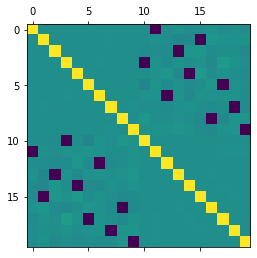

In [557]:
WtW = torch.mm(no_linear_model_cor20.W[-1], no_linear_model_cor20.W[-1].T)
plt.matshow(WtW.detach().numpy())